# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d25/9b8a3493628de4a545ca348012ca3563e0a85b955446eef6f8fdafb5.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **City of Victoria, Central and Western District, Hong Kong**, and the stations the data comes from are shown on the map below.

In [26]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]
    
    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(25,'9b8a3493628de4a545ca348012ca3563e0a85b955446eef6f8fdafb5')

In [259]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d25/9b8a3493628de4a545ca348012ca3563e0a85b955446eef6f8fdafb5.csv')

#convert date string to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

#there are 71 stations in the dataset given to me
stations_num = len(df['ID'].unique())

#the data I choose to visualize is from the station in Macau, MCM00045011  22.1500  113.5920    6.1    MACAU INTL  45011
#print(df['ID'].unique())
df = df[df['ID'] == 'MCM00045011']
del df['ID']

#record low and high from 2005-2014
#df drop leap days
#find leap days df[(df['Date'].dt.month ==2) & (df['Date'].dt.day == 29)]
df.drop([146490, 403750], inplace=True)

df_0514 = df[df['Date'].dt.year != 2015]
df_2015 = df[df['Date'].dt.year == 2015]

record_high = []
tmaxmask = df_0514['Element'] == 'TMAX'
tmaxdays = df_0514[tmaxmask]['Date'].unique()
plot_tmaxdays = list(map(pd.to_datetime, tmaxdays))
for i in range(len(plot_tmaxdays)):
    plot_tmaxdays[i] = plot_tmaxdays[i].replace(year=2015)
plot_tmaxdays = list(set(plot_tmaxdays))

record_low = []
tminmask = df_0514['Element'] == 'TMIN'
tmindays = df_0514[tminmask]['Date'].unique()
plot_tmindays = list(map(pd.to_datetime, tmindays))
for i in range(len(plot_tmindays)):
    plot_tmindays[i] = plot_tmindays[i].replace(year=2015)
plot_tmindays = list(set(plot_tmindays))

for day in plot_tmaxdays:
    #record high
    daymask_m = df_0514['Date'].dt.month == day.month
    daymask_d = df_0514['Date'].dt.day == day.day
    dayid_high = df_0514[daymask_m & daymask_d]['Data_Value'].idxmax()
    record_high.append(df.loc[dayid_high]['Data_Value'])
    
for day in plot_tmindays:
    #record low
    daymask_m = df_0514['Date'].dt.month == day.month
    daymask_d = df_0514['Date'].dt.day == day.day
    dayid_low = df_0514[daymask_m & daymask_d]['Data_Value'].idxmin()
    record_low.append(df.loc[dayid_low]['Data_Value'])


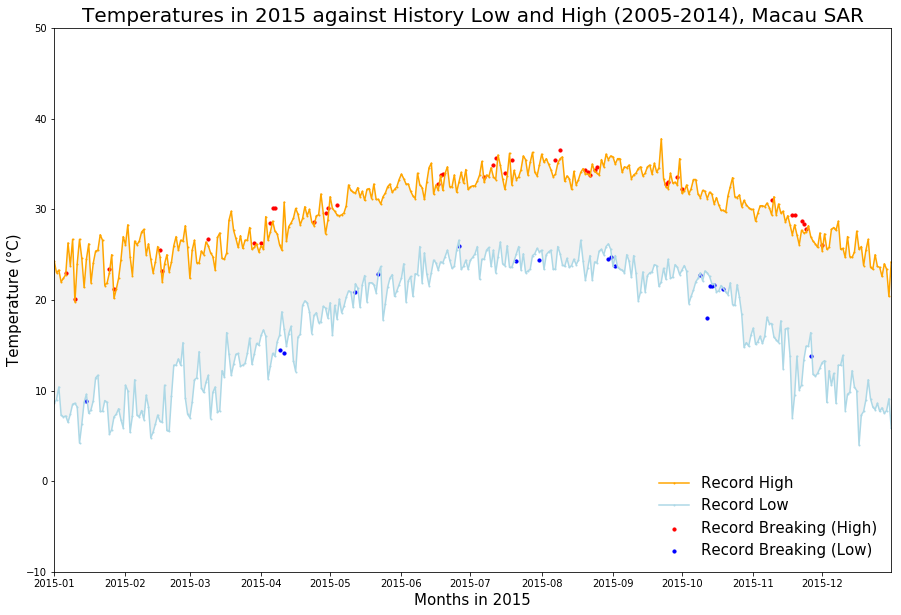

In [324]:
fig = plt.gcf()
fig.set_size_inches(15, 10)

plot_tmaxdays, record_high = zip(*sorted(zip(plot_tmaxdays, record_high)))
high = [x / 10 for x in record_high]
plt.plot(plot_tmaxdays, high, '-o', markersize = 1, c='orange', label="Record High")
plot_tmindays, record_low = zip(*sorted(zip(plot_tmindays, record_low)))
low = [x / 10 for x in record_low]
plt.plot(plot_tmindays, low, '-o', markersize = 1, c= 'lightblue', label="Record Low")

#fill
plt.gca().fill_between(plot_tmaxdays,
                       low, high, 
                       facecolor='grey', 
                       alpha=0.1)


days2015_high = list(map(pd.to_datetime, df_2015[df_2015['Element']=='TMAX']['Date']))
val2015_high = [x/10 for x in df_2015[df_2015['Element']=='TMAX']['Data_Value'].tolist()]
days2015_high, val2015_high = zip(*sorted(zip(days2015_high, val2015_high)))

#compare , craete dict and access by day key (high)
high_dict = dict(zip(plot_tmaxdays, high))
plot_2015_values = []
plot_2015_days = []
for index, day in enumerate(days2015_high):
    if val2015_high[index] > high_dict.get(day):
        plot_2015_values.append(val2015_high[index])
        plot_2015_days.append(day)

plt.scatter(plot_2015_days, plot_2015_values, s=10, c='red', label="Record Breaking (High)")


days2015_low = list(map(pd.to_datetime, df_2015[df_2015['Element']=='TMIN']['Date']))
val2015_low = [x/10 for x in df_2015[df_2015['Element']=='TMIN']['Data_Value'].tolist()]
days2015_low, val2015_low = zip(*sorted(zip(days2015_low, val2015_low)))

#compare , craete dict and access by day key (low)
low_dict = dict(zip(plot_tmaxdays, low))
plot_2015_values_low = []
plot_2015_days_low = []
for index, day in enumerate(days2015_low):
    if val2015_low[index] < low_dict.get(day):
        plot_2015_values_low.append(val2015_low[index])
        plot_2015_days_low.append(day)

plt.scatter(plot_2015_days_low, plot_2015_values_low, s=10, c='blue', label="Record Breaking (Low)")

ax = plt.gca()
ax.axis([pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'), -10, 50])
plt.xlabel("Months in 2015", fontsize=15)
plt.ylabel("Temperature (°C)", fontsize=15)
plt.title("Temperatures in 2015 against History Low and High (2005-2014), Macau SAR", fontsize=20)
plt.legend(loc=4, frameon=False, prop={'size': 15})
plt.show()


In [325]:
fig.savefig('macau.png')
plt.savefig('Macau.png')